In [2]:
import tarfile
import urllib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from kneed import KneeLocator

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler

import netCDF4 as nc
import os
import xarray as xr
from source2 import *

## Data
loading the entired data from July 15 to October months in 2021. The data is resample by the hour per day and store in a single data frame

In [3]:
def monthly_df(path):
    """
    
    
    
    
    """
    columns = (np.array([i for i in range(200, 5200, 100)]))
    #Montly data frames
    dfCnr = pd.DataFrame()
    dfBeta = pd.DataFrame()
    dfSpectral= pd.DataFrame()
    dfWind = pd.DataFrame()
    dfatm_pbl = pd.DataFrame()

    for folder in sorted(os.listdir(path))[1:-1]: #[1:-1] means I skipp the dummy file names and last unwated file, it might 
                                                    #need to be change
        date = folder[3:]

        #collects and puts together the data for the whole day
        path = fixed_p + folder + '/'
        variables = VAREXTRACT(path)
        variables.extract()
        cnr_ = variables.cnr_day
        time = pd.to_datetime(variables.time_day, unit = 's', utc = True)
        wind = variables.ver_wind_speed 
        spect_width = variables.spectral_width_day
        beta = variables.relat_beta_day 
        atm = variables.atm_structures
        #daily dataframes atm_structures 
        df_cnr =dataframe_set(cnr_, time, date).resample('30T').mean()


        df_beta = dataframe_set(beta, time, date).resample('30T').mean()

        df_spectralWidth = dataframe_set(spect_width, time, date).resample('30T').mean()


        df_wind = dataframe_set(wind, time, date).resample('30T').mean()

        df_atm= dataframe_set(atm, time, date).resample('30T').mean()


        #concatanating to all DF
        dfCnr =pd.concat([dfCnr, df_cnr], axis =0)
        dfBeta = pd.concat([dfBeta, df_beta], axis = 0)
        dfSpectral = pd.concat([dfSpectral, df_spectralWidth], axis = 0)
        dfWind = pd.concat([dfWind, df_wind], axis =0)
        dfatm_pbl = pd.concat([dfatm_pbl, df_atm], axis = 0)



In [ ]:
fixed_p='/Users/jenifervivar/Desktop/NERTO_2022/Lidar_Data/Vertical_data/'
columns = (np.array([i for i in range(200, 5200, 100)]))
#Montly data frames
dfCnr = pd.DataFrame()
dfBeta = pd.DataFrame()
dfSpectral= pd.DataFrame()
dfWind = pd.DataFrame()
dfatm_pbl = pd.DataFrame()

for folder in sorted(os.listdir(fixed_p))[1:-1]:
    
    date = folder[3:]

    #collects and puts together the data for the whole day
    path = fixed_p + folder + '/'
    variables = VAREXTRACT(path)
    variables.extract()
    cnr_ = variables.cnr_day
    time = pd.to_datetime(variables.time_day, unit = 's', utc = True)
    wind = variables.ver_wind_speed 
    spect_width = variables.spectral_width_day
    beta = variables.relat_beta_day 
    atm = variables.atm_structures
    #daily dataframes atm_structures 
    df_cnr =dataframe_set(cnr_, time, date).resample('30T').mean()


    df_beta = dataframe_set(beta, time, date).resample('30T').mean()

    df_spectralWidth = dataframe_set(spect_width, time, date).resample('30T').mean()


    df_wind = dataframe_set(wind, time, date).resample('30T').mean()
    
    df_atm= dataframe_set(atm, time, date).resample('30T').mean()


    #concatanating to all DF
    dfCnr =pd.concat([dfCnr, df_cnr], axis =0)
    dfBeta = pd.concat([dfBeta, df_beta], axis = 0)
    dfSpectral = pd.concat([dfSpectral, df_spectralWidth], axis = 0)
    dfWind = pd.concat([dfWind, df_wind], axis =0)
    dfatm_pbl = pd.concat([dfatm_pbl, df_atm], axis = 0)

print(dfCnr.head())    

In [ ]:
dfCnr.plot(style = '.', legend = False)
plt.show()

In [ ]:
sns.heatmap(dfCnr.T, cmap = 'seismic')

In [ ]:
(dfCnr.resample('1H').mean()).plot(style='.', legend =False)

In [ ]:
dfBeta.plot(style='.', legend = False)
plt.show()

In [ ]:
dfSpectral.plot(style = '.', legend = False)
plt.show()

In [ ]:
dfWind .plot(style = '.', legend = False)

In [ ]:
p = '/Users/jenifervivar/Desktop/NERTO_2022/EXTRA_DATA/wrf_vmixingoutput.csv'
df_wrf =pd.read_csv(p)
df_wrf.index = pd.to_datetime(df_wrf['date'])
df_wrf.head()

<AxesSubplot:xlabel='date'>

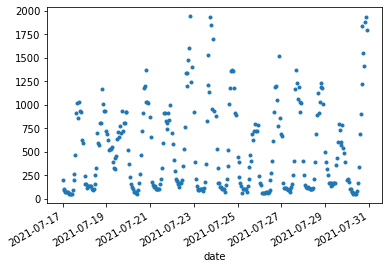

In [11]:
df_wrf.MixHgt.plot(style='.', legend = False)

In [13]:
atm_pbl = pbl_lidar(dfatm_pbl)
atm_pbl

Time
2021-07-17 14:00:00+00:00    200.0
2021-07-17 15:00:00+00:00    767.0
2021-07-17 16:00:00+00:00    200.0
2021-07-17 17:00:00+00:00    462.0
2021-07-17 18:00:00+00:00      NaN
                             ...  
2021-10-13 11:00:00+00:00      NaN
2021-10-13 12:00:00+00:00      NaN
2021-10-13 13:00:00+00:00      NaN
2021-10-13 14:00:00+00:00      NaN
2021-10-13 15:00:00+00:00    700.0
Freq: H, Name: Heigth, Length: 2114, dtype: float64

In [14]:
atm_pbl_ = pd.DataFrame(atm_pbl)
atm_pbl_

,Heigth
Time,
2021-07-17 14:00:00+00:00,200.0
2021-07-17 15:00:00+00:00,767.0
2021-07-17 16:00:00+00:00,200.0
2021-07-17 17:00:00+00:00,462.0
2021-07-17 18:00:00+00:00,NaN
...,...
2021-10-13 11:00:00+00:00,NaN
2021-10-13 12:00:00+00:00,NaN
2021-10-13 13:00:00+00:00,NaN


In [15]:
atm_pbl.isna().sum()

1539

In [16]:
atm_pbl_ = atm_pbl.dropna()

In [1]:
atm_pbl_.plot(style='.')
plt.show()

NameError: name 'atm_pbl_' is not defined

In [18]:
cnr_pbl_mean = pbl_height(dfCnr, stat = 'mean',var_type = 'CNR')
cnr_pbl_med = pbl_height(dfCnr, stat = 'median',var_type = 'CNR')
cnr_pbl_std =pbl_height(dfCnr,var_type = 'CNR')
wind_var = pbl_height(dfCnr, stat = 'var', var_type= 'wind')

In [19]:
df_mean = pd.DataFrame({'cnr_mean':cnr_pbl_mean[1]}, index = cnr_pbl_mean[0])
df_med =  pd.DataFrame({'cnr_med':cnr_pbl_med[1]}, index = cnr_pbl_med[0])
df_std = pd.DataFrame({'cnr_std':cnr_pbl_std[1]}, index = cnr_pbl_std[0])
wind_var_df = pd.DataFrame({'wind_var':wind_var[1]}, index = wind_var[0])

In [33]:
df_pbl_all= pd.DataFrame()
dfs = [df_med,df_mean, wind_var_df, atm_pbl_]
for df in dfs:
    df_pbl_all = pd.concat([df_pbl_all,df], axis = 1)
    
df_pbl_all.head()

,cnr_med,cnr_mean,wind_var,Heigth
2021-07-17 00:00:00+00:00,1100,1100,5100,NaN
2021-07-17 01:00:00+00:00,1100,1100,5100,NaN
2021-07-17 02:00:00+00:00,1000,1000,5100,NaN
2021-07-17 03:00:00+00:00,900,900,5100,NaN
2021-07-17 04:00:00+00:00,900,900,5100,NaN


In [34]:
df_pbl_all.isna().sum()

cnr_med        0
cnr_mean       0
wind_var       0
Heigth      1561
dtype: int64

In [43]:
df_pbl_all_= df_pbl_all.dropna()
df_pbl_all_ =df_pbl_all[['cnr_med'	,'cnr_mean','Heigth']]

In [47]:
dfCnr

,5100,5000,4900,4800,4700,4600,4500,4400,4300,4200,...,1100,1000,900,800,700,600,500,400,300,200
2021-07-17 00:00:00+00:00,-32.894347,-32.912306,-32.893236,-32.799486,-32.592181,-31.747681,-30.613208,-30.111236,-29.769028,-29.663639,...,-7.400500,-7.695264,-8.325139,-9.250833,-10.248569,-11.074556,-12.019889,-13.237972,-14.734125,-15.868083
2021-07-17 00:30:00+00:00,-32.892042,-32.883556,-32.845875,-32.887806,-32.608278,-31.363069,-29.635667,-29.614653,-30.123778,-30.050097,...,-6.467861,-6.619139,-7.227306,-8.329458,-9.520403,-10.474583,-11.430486,-12.406708,-13.555611,-15.222236
2021-07-17 01:00:00+00:00,-32.861097,-32.948556,-32.869500,-32.858181,-32.909847,-32.660139,-31.771931,-29.974958,-29.935806,-30.835958,...,-5.694417,-5.837528,-6.460708,-7.712542,-9.170861,-10.580597,-11.963986,-13.231486,-14.557639,-15.581000
2021-07-17 01:30:00+00:00,-33.041125,-32.960986,-32.942194,-32.915458,-32.779931,-32.868361,-32.562611,-31.848292,-31.381958,-31.621597,...,-5.295847,-5.374014,-5.967597,-7.246181,-8.992542,-10.740139,-12.389542,-13.781111,-15.172264,-16.007583
2021-07-17 02:00:00+00:00,-32.887069,-32.908097,-32.747333,-32.865333,-32.828847,-32.899819,-32.780917,-32.605042,-31.796750,-31.429569,...,-4.440556,-4.507431,-5.158722,-6.476194,-8.137500,-9.701694,-11.639764,-13.772611,-15.169625,-15.587750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-13 21:30:00+00:00,-32.930597,-32.984444,-32.949708,-32.999403,-32.946583,-33.080667,-32.923569,-32.920625,-32.973097,-32.890792,...,-32.842875,-30.492861,-9.454375,8.871486,10.862250,5.080403,-2.144694,-5.939486,-8.137861,-10.013861
2021-10-13 22:00:00+00:00,-32.914478,-32.890445,-32.908581,-32.931641,-32.893658,-32.953588,-32.955786,-32.914465,-33.034576,-32.882058,...,-30.668136,-17.239179,3.955480,10.404715,7.098637,4.582253,-2.659291,-5.999318,-8.626342,-10.408220
2021-10-13 22:30:00+00:00,-33.000014,-32.939694,-32.926236,-32.928792,-32.949333,-32.906611,-32.850306,-32.796222,-32.976139,-32.891319,...,-15.616403,16.449931,19.769986,-0.542000,-4.764028,-5.975778,-6.228444,-6.717444,-8.705903,-10.797764
2021-10-13 23:00:00+00:00,-32.994072,-32.937799,-32.836000,-32.907237,-32.916101,-32.808820,-32.844633,-33.004892,-32.910273,-32.933511,...,15.997410,14.010705,1.311568,-2.378432,-4.122432,-6.194748,-7.225338,-8.044518,-9.410417,-10.744029


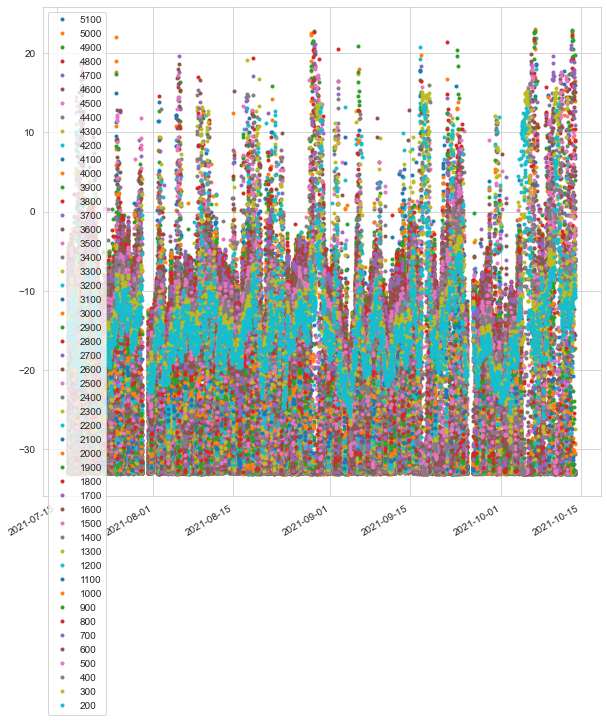

In [46]:
import datetime
sns.set_style('whitegrid')

#fig, ax =plt.subplots(figsize = (10,10))


#dfCnr.plot(style='.', figsize = (10,10))
ax = plt.gca()
#fig.autofmt_xdate()
#d1 = datetime.datetime(2021,7,15,0)
#d2 = d1 + datetime.timedelta(days = 10)
#print(d1,d2)
#ax.set_xlim(d1,d2)


#plt.plot(df_mean, label = "mean")
#plt.plot(wind_var_df, label = "median")
#plt.plot(df_std, label = "wind_var", alpha = 0.8)
#plt.plot(atm_pbl_, label = 'pblh_calculation', style='.')
#plt.plot(df_mh, label="wrf_mxh", alpha = 0.6)

#d1 = datetime.datetime(2021,7,15)
#d2 = datetime.datetime(2021,8,1)
#plt.legend()
plt.show()

In [24]:
plot_all(july17_cnr,lidar_pbl17,july17_cnrmean, july17_cnrstd,july17_cnrmedian, wind_var,date)

NameError: name 'july17_cnr' is not defined

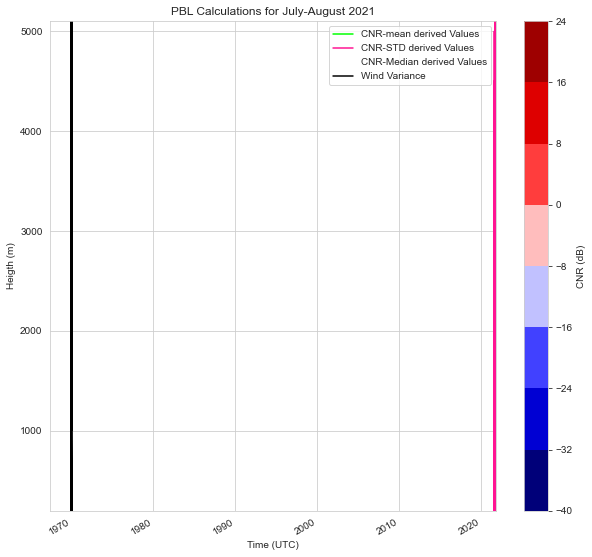

In [26]:
plot_all(dfCnr,atm_pbl,cnr_pbl_mean,cnr_pbl_med, cnr_pbl_std, wind_var, "July-August 2021")

In [27]:
df_pbl_all['cnr_med'].value_counts()

900     422
1000    346
800     257
1100    154
200     146
700     128
300     103
500      80
600      74
1200     72
400      68
1300     48
1400     37
1500     28
1700     27
1600     27
1800     19
1900     15
2000     15
2100     11
2300     10
2200      7
2400      6
4500      5
2700      4
5000      3
3400      3
3300      3
5100      3
2600      3
3100      2
2800      2
2500      2
4200      1
4100      1
3000      1
3700      1
2900      1
3600      1
Name: cnr_med, dtype: int64

## Feature reduction
I would like to only get the most relevant features of each data frame. Each data frame is specific to wind, cnr, etc. The goal is to have all these important values combined in a data frame

In [29]:
def reducer(df, n_features = 2):
    scaler = StandardScaler()
    std_df = scaler.fit_transform(df)
    pca = PCA(n_features)
    x = pca.fit_transform(std_df)
    var= pca.explained_variance_ratio_
    return x, var

In [30]:
cnr,v = reducer(dfCnr)
wind, v_1 = reducer(dfWind)
beta, v_2 = reducer(dfBeta)
espWidth, v_3 = reducer(dfSpectral)

In [31]:
print(v, v_1, v_2, v_3)

[0.43187139 0.14496053] [0.42430761 0.132484  ] [0.07432275 0.06183959] [0.52900852 0.18747235]


In [ ]:
all_df.head(-5)

In [ ]:
all_x = 

In [ ]:
std_cnr = scaler.fit_transform(dfCnr)

pca = PCA(3)
cnr_ = pca.fit_transform(std_cnr)

In [ ]:
pca.singular_values_

In [ ]:
#standarizing the data and reducing the amount of inputs I need
scaler = StandardScaler()
std_df = scaler.fit_transform(dfWind)
print(std_df)
pca = PCA(3)
w = pca.fit_transform(std_df)
print(x, type(x))

In [ ]:
#verifying % of data explained by variables
pca.components_

In [ ]:
sse = []
for k in range(2, 11):
    kmeans = KMeans(k)
    kmeans.fit(x)
    sse.append(kmeans.inertia_)

In [ ]:
#plotting the sum of squares distances to get ideal k value
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), sse)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
kl = KneeLocator(
range(2, 11), sse, curve="convex", direction="decreasing")

kl.elbow

In [ ]:
kmeans = KMeans(5)
identified_custers = kmeans.fit_predict(x)
identified_custers

In [ ]:
x[:,0]

In [ ]:
plt.scatter(x[:,0],x[:,1],c=identified_custers,cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker = '*', c  = 'black')
plt.show()

## Kmeans pipeline

In [ ]:
preprocessor = Pipeline([("scaler",  StandardScaler()), ("pca", PCA(n_components=2, random_state=42)),])

In [ ]:
clusterer = Pipeline([("kmeans",KMeans(n_clusters=10,init="k-means++",n_init=50,max_iter=500,random_state=42,),),])

In [ ]:
pipe = Pipeline([("preprocessor", preprocessor),("clusterer", clusterer)])